In [1]:
!git clone https://github.com/sof1a03/DSS_groupproject.git

Cloning into 'DSS_groupproject'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 506 (delta 30), reused 3 (delta 3), pack-reused 451 (from 2)
Receiving objects: 100% (506/506), 26.62 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (193/193), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import confusion_matrix, normalized_mutual_info_score

!pip -q install pgeocode # PC4 -> (lat, lon) without GIS files

import pgeocode

In [55]:
pd.options.display.float_format = "{:,.4f}".format

REGIONS_PATH = "/content/DSS_groupproject/Data/Final/REGIONAL.csv"
GEMEENTE_PATH = "/content/merged_pc4_gemeente.csv"
regions = pd.read_csv(REGIONS_PATH)
regions.info()
regions.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5701 entries, 0 to 5700
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nbh_code                       5701 non-null   object 
 1   avg_household_size             5701 non-null   float64
 2   avg_house_value_woz            5701 non-null   float64
 3   urbanization                   5701 non-null   float64
 4   std_avg_household_size         5701 non-null   float64
 5   std_avg_house_value_woz        5701 non-null   float64
 6   std_urbanization               5701 non-null   float64
 7   pc4                            5701 non-null   int64  
 8   p_gasoline                     5701 non-null   float64
 9   p_diesel                       5701 non-null   float64
 10  p_electric                     5701 non-null   float64
 11  p_hybrid                       5701 non-null   float64
 12  avg_yearly_income_k            5701 non-null   f

,nbh_code,avg_household_size,avg_house_value_woz,urbanization,std_avg_household_size,std_avg_house_value_woz,std_urbanization,pc4,p_gasoline,p_diesel,...,std_p_inhb_15_to_25_year,std_p_inhb_25_to_45_year,std_p_inhb_45_to_65_year,std_p_inhb_65_year_older,p_compact,p_medium,p_large,p_suv,p_mpv,p_sports
0,0363AF01,1.6000,832.0000,1.0000,-1.4928,2.3711,-1.7172,1011,0.8048,0.1142,...,0.2986,1.7435,-0.6739,-0.2558,0.3386,0.5730,0.1958,0.1723,0.3927,0.3734
1,0363AF02,1.6000,588.0000,1.0000,-1.4928,0.9314,-1.7172,1011,0.8048,0.1142,...,0.2986,1.7435,-0.6739,-0.2558,0.3386,0.5730,0.1958,0.1723,0.3927,0.3734
2,0363AF03,1.6000,755.0000,1.0000,-1.4928,1.9168,-1.7172,1011,0.8048,0.1142,...,0.2986,1.7435,-0.6739,-0.2558,0.3386,0.5730,0.1958,0.1723,0.3927,0.3734


## Feature preparation

We focus on features tied to EV adoption and capacity:
- `p_electric`, `p_hybrid`, `p_gasoline`, `p_diesel`
- `avg_yearly_income_k`, `urbanization`, `avg_household_size`
- `inhabitants_total` (kept for interpretation / sizing, **excluded from clustering**)

We also create helper composites:
- `p_fossil = p_gasoline + p_diesel` (used in EV Potential Index)


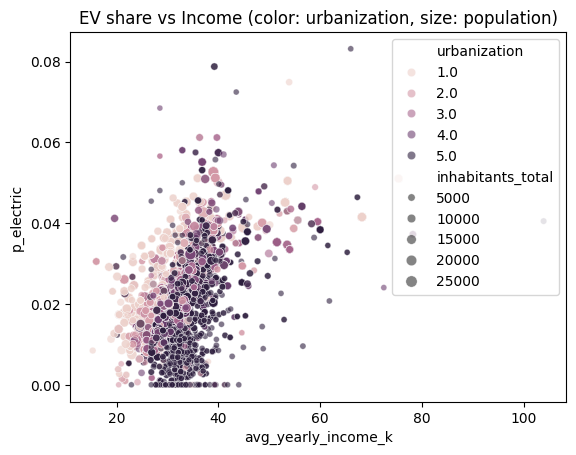

In [56]:
# Pick core features
feat = [
    "p_electric", "p_hybrid", "p_gasoline", "p_diesel",
    "avg_yearly_income_k", "urbanization", "avg_household_size",
    "inhabitants_total", "pc4"
]

# Keep valid rows and force numeric
R = regions.dropna(subset=feat).copy()
for c in feat:
    R[c] = pd.to_numeric(R[c], errors="coerce")
R = R.dropna(subset=feat).copy()

# Composite fossil share
R["p_fossil"] = R["p_gasoline"] + R["p_diesel"]

# Quick EDA plot (optional)
sns.scatterplot(data=R, x="avg_yearly_income_k", y="p_electric",
                hue="urbanization", size="inhabitants_total", alpha=0.6)
plt.title("EV share vs Income (color: urbanization, size: population)")
plt.show()


## Clustering

We cluster regions by *EV readiness* using KMeans on standardized features (excluding `inhabitants_total`).  
PCA (up to 5 comps) is applied for de-noising and to provide a 2D visualization space.  
`k` is selected by **silhouette score** over k=2..6.


In [57]:
clust_cols = [
    "p_electric", "p_hybrid", "p_gasoline", "p_diesel",
    "avg_yearly_income_k", "urbanization", "avg_household_size"
]

X = R[clust_cols].copy()

# Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# PCA for downstream clustering + plotting
pca = PCA(n_components=min(5, Xs.shape[1]))
X_p = pca.fit_transform(Xs)

# Pick k by silhouette
k_results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_p)
    sil = silhouette_score(X_p, labels)
    k_results.append((k, sil))
    print(f"k={k} silhouette={sil:.4f}")

best_k = max(k_results, key=lambda t: t[1])[0]
print("\nBest k (by silhouette):", best_k)

# Final KMeans
km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
R["ev_cluster"] = km.fit_predict(X_p)

# Silhouette on final model
sil_final = silhouette_score(X_p, R["ev_cluster"])
print("Final silhouette:", round(sil_final, 4))


k=2 silhouette=0.2585
k=3 silhouette=0.2691
k=4 silhouette=0.2477
k=5 silhouette=0.2362
k=6 silhouette=0.2225

Best k (by silhouette): 3
Final silhouette: 0.27


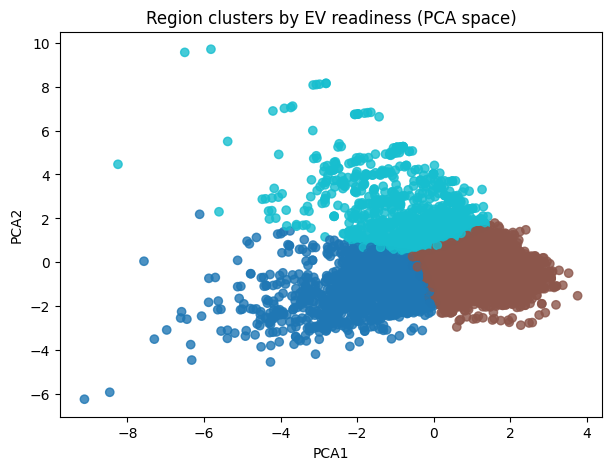

In [58]:
# PCA scatter (2D)
plt.figure(figsize=(7,5))
plt.scatter(X_p[:,0], X_p[:,1], c=R["ev_cluster"], cmap="tab10", alpha=0.8)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title("Region clusters by EV readiness (PCA space)")
plt.show()

### Agglomerative (Hierarchical) Clustering

We complement K-Means with **Agglomerative clustering (Ward linkage)**:

- **How it works:** start with each region as its own cluster; iteratively merge the two clusters that cause the **smallest increase in within-cluster variance** (Ward’s criterion).
- **Why use it here:** it can capture **nested / non-spherical** structures and provides a **dendrogram** to inspect how clusters form across levels.
- **Pipeline:** we reuse the **standardized + PCA** representation (`X_p`) to (a) denoise/ decorrelate and (b) keep it tractable at ~5K rows.


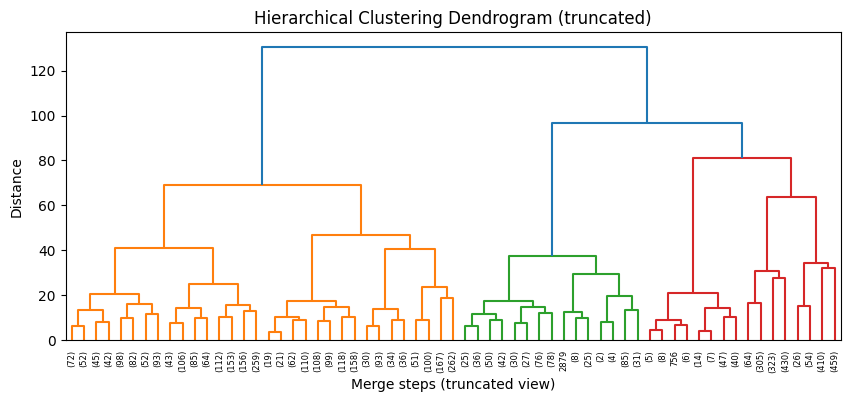

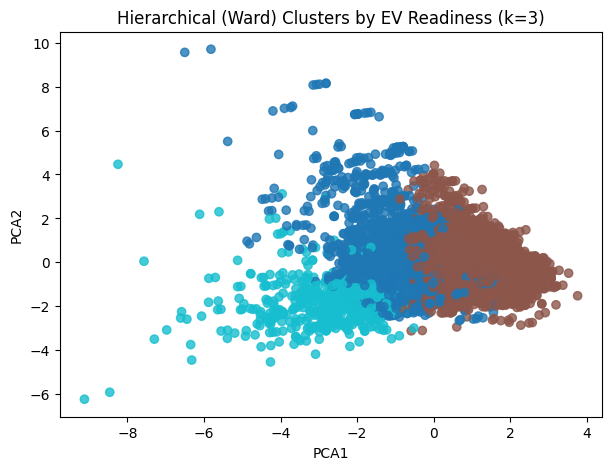

Hierarchical silhouette: 0.2319


In [59]:
Z = linkage(X_p, method="ward")

plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Merge steps (truncated view)")
plt.ylabel("Distance")
plt.show()

# --- Choose number of clusters (use KMeans best_k for comparability, or change) ---
n_hier = best_k  # keep same k as KMeans for fair comparison
hc = AgglomerativeClustering(n_clusters=n_hier, linkage="ward")
R["ev_cluster_hier"] = hc.fit_predict(X_p)

# --- Visualize hierarchical labels in PCA space ---
plt.figure(figsize=(7,5))
plt.scatter(X_p[:,0], X_p[:,1], c=R["ev_cluster_hier"], cmap="tab10", alpha=0.8)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title(f"Hierarchical (Ward) Clusters by EV Readiness (k={n_hier})")
plt.show()

# --- Silhouette for hierarchical labels (on the same X_p) ---
sil_hier = silhouette_score(X_p, R["ev_cluster_hier"])
print("Hierarchical silhouette:", round(sil_hier, 4))

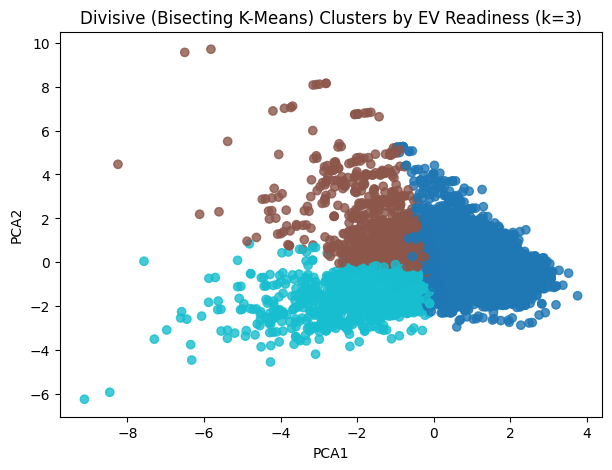

Divisive (Bisecting KMeans) silhouette: 0.2553


In [60]:
# --- Divisive clustering using Bisecting K-Means ---
div_kmeans = BisectingKMeans(n_clusters=best_k, random_state=42)
R["ev_cluster_div"] = div_kmeans.fit_predict(X_p)

# --- Visualize divisive clusters in PCA space ---
plt.figure(figsize=(7,5))
plt.scatter(X_p[:,0], X_p[:,1], c=R["ev_cluster_div"], cmap="tab10", alpha=0.8)
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.title(f"Divisive (Bisecting K-Means) Clusters by EV Readiness (k={best_k})")
plt.show()

# --- Silhouette score for divisive clustering ---
sil_div = silhouette_score(X_p, R["ev_cluster_div"])
print("Divisive (Bisecting KMeans) silhouette:", round(sil_div, 4))

### Comparing Clusterings: Purity and NMI

We compare the different clustering results — **K-Means**, **Agglomerative (Hierarchical)**, and **Divisive (Bisecting K-Means)** — using two complementary agreement metrics:

- **Purity:**  
  Measures how *homogeneous* each predicted cluster is relative to a reference partition.  
  In the absence of ground-truth labels, we use **K-Means** as the reference baseline to evaluate the alignment of Hierarchical and Divisive clusters.  
  A higher purity indicates stronger overlap with the baseline structure.

- **NMI (Normalized Mutual Information):**  
  A symmetric, label-invariant measure of shared information between two clusterings, ranging from 0 to 1.  
  It captures the overall **agreement and consistency** between partitions regardless of label naming.

> **Note:** KL divergence is not suitable for comparing cluster label assignments because it measures differences between probability distributions rather than categorical correspondences.  
> For clustering evaluation, **Purity** and **NMI** are the standard choices to quantify structural similarity between models.

In [61]:
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score

def purity_score(y_ref, y_pred):
    cm = confusion_matrix(y_ref, y_pred)
    return np.sum(np.max(cm, axis=0)) / np.sum(cm)

y_km   = R["ev_cluster"].to_numpy()
y_hier = R["ev_cluster_hier"].to_numpy()
y_div  = R["ev_cluster_div"].to_numpy()

# Agreement metrics
purity_hier = purity_score(y_km, y_hier)
purity_div  = purity_score(y_km, y_div)
nmi_hier    = normalized_mutual_info_score(y_km, y_hier)
nmi_div     = normalized_mutual_info_score(y_km, y_div)

# --- Print summary ---
print("\n--- Cluster Comparison Summary ---")
print(f"Silhouette  (KMeans)        : {sil_final:.4f}")
print(f"Silhouette  (Hierarchical)  : {sil_hier:.4f}")
print(f"Silhouette  (Divisive)      : {sil_div:.4f}")
print(f"Purity (Hier | ref=KMeans)  : {purity_hier:.4f}")
print(f"Purity (Div  | ref=KMeans)  : {purity_div:.4f}")
print(f"NMI (KMeans vs Hier)        : {nmi_hier:.4f}")
print(f"NMI (KMeans vs Divisive)    : {nmi_div:.4f}")

# --- Recommendation logic (based on Silhouette) ---
if sil_hier > max(sil_final, sil_div):
    best_method = "Hierarchical (Ward)"
elif sil_div > max(sil_final, sil_hier):
    best_method = "Divisive (Bisecting K-Means)"
elif sil_final > max(sil_hier, sil_div):
    best_method = "KMeans"
else:
    best_method = "Equal / tie"

print(f"\n Recommended clustering method based on silhouette: {best_method}")



--- Cluster Comparison Summary ---
Silhouette  (KMeans)        : 0.2700
Silhouette  (Hierarchical)  : 0.2319
Silhouette  (Divisive)      : 0.2553
Purity (Hier | ref=KMeans)  : 0.6913
Purity (Div  | ref=KMeans)  : 0.7892
NMI (KMeans vs Hier)        : 0.3526
NMI (KMeans vs Divisive)    : 0.5333

 Recommended clustering method based on silhouette: KMeans


## Cluster profiles

We summarize median feature values per cluster to interpret **archetypes**  
(e.g., wealthier, urban clusters with higher `p_electric`).


In [9]:
profile_cols = [
    "p_electric", "p_hybrid", "p_gasoline", "p_diesel",
    "avg_yearly_income_k", "urbanization", "avg_household_size", "inhabitants_total"
]
profile = R.groupby("ev_cluster")[profile_cols].median().reset_index().sort_values("p_electric", ascending=False)
profile


,ev_cluster,p_electric,p_hybrid,p_gasoline,p_diesel,avg_yearly_income_k,urbanization,avg_household_size,inhabitants_total
2,2,0.0347,0.0210,0.8223,0.1036,38.0000,3.0000,2.3000,"8,955.0000"
1,1,0.0204,0.0119,0.8559,0.0991,30.4000,2.0000,2.1000,"9,190.0000"
0,0,0.0171,0.0133,0.8000,0.1523,33.0000,5.0000,2.5000,"3,390.0000"


In [62]:
order = profile["ev_cluster"].tolist()
label_map = {c: f"Cluster_{i+1}" for i, c in enumerate(order)}
R["cluster_label"] = R["ev_cluster"].map(label_map)

## EV Potential Index

A simple composite that ranks *where EV adoption should accelerate next*.

We z-score each component and combine:
- Positive drivers: **income**, **urbanization**, **p_hybrid**
- Negative drivers: **p_diesel**, **p_gasoline** (fossil baseline)

$$
\text{EV_Potential} = \frac{z(\text{income}) + z(\text{urbanization}) + z(\text{p_hybrid}) - z(\text{p_diesel}) - z(\text{p_gasoline})}{5}
$$

We then min–max scale to 0–100 for presentation.  
*(This is a heuristic index; adjust weights if you want to emphasize a factor.)*


In [11]:
potential_cols = ["avg_yearly_income_k", "urbanization", "p_hybrid", "p_diesel", "p_gasoline"]
Z = R[potential_cols].copy()

# z-score each column
Z = (Z - Z.mean()) / (Z.std(ddof=0).replace(0, 1e-9))

R["EV_Potential_raw"] = (
    Z["avg_yearly_income_k"] + Z["urbanization"] + Z["p_hybrid"]
    - Z["p_diesel"] - Z["p_gasoline"]
) / 5.0

# Scale to 0-100
min_, max_ = R["EV_Potential_raw"].min(), R["EV_Potential_raw"].max()
R["EV_Potential_0_100"] = 100 * (R["EV_Potential_raw"] - min_) / (max_ - min_ + 1e-9)

# Rank and preview
ev_pot = R[["pc4", "EV_Potential_0_100", "EV_Potential_raw", "cluster_label",
            "p_electric", "p_hybrid", "p_diesel", "p_gasoline",
            "avg_yearly_income_k", "urbanization", "inhabitants_total"]].copy()

ev_pot.sort_values("EV_Potential_0_100", ascending=False).head(10)


,pc4,EV_Potential_0_100,EV_Potential_raw,cluster_label,p_electric,p_hybrid,p_diesel,p_gasoline,avg_yearly_income_k,urbanization,inhabitants_total
2482,3735,100.0000,3.9558,Cluster_1,0.0405,0.0545,0.1083,0.7883,103.9000,5.0000,"1,735.0000"
367,1101,91.6551,3.5329,Cluster_3,0.0000,0.0000,0.0000,0.0000,34.9000,2.0000,900.0000
368,1101,89.0852,3.4027,Cluster_3,0.0000,0.0000,0.0000,0.0000,34.9000,1.0000,900.0000
756,1358,88.2716,3.3614,Cluster_1,0.0832,0.0685,0.1468,0.6912,66.0000,5.0000,600.0000
2879,3899,85.6862,3.2304,Cluster_1,0.0000,0.1034,0.2759,0.5862,35.3000,5.0000,70.0000
1656,2111,78.3788,2.8601,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,5.0000,"4,865.0000"
1658,2111,75.8088,2.7299,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,4.0000,"4,865.0000"
1659,2111,75.8088,2.7299,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,4.0000,"4,865.0000"
1657,2111,73.2388,2.5996,Cluster_1,0.0372,0.0474,0.1014,0.8071,78.2000,3.0000,"4,865.0000"
499,1184,71.2898,2.5009,Cluster_1,0.0241,0.0481,0.0928,0.8316,72.5000,4.0000,610.0000


## Opportunity sizing

We size opportunities by combining potential with population:
$$
\text{Opportunity} = \text{EV_potential_0_100} \times \log(1 + \text{inhabitants_total})
$$
This favors regions that are both *ready* and *large enough* to matter.


In [12]:
R["Opportunity"] = R["EV_Potential_0_100"] * np.log1p(R["inhabitants_total"])

opp = R[["pc4", "cluster_label", "EV_Potential_0_100", "inhabitants_total", "Opportunity",
         "p_electric", "p_hybrid", "p_diesel", "p_gasoline",
         "avg_yearly_income_k", "urbanization"]].copy()

opp.sort_values("Opportunity", ascending=False).head(10)


,pc4,cluster_label,EV_Potential_0_100,inhabitants_total,Opportunity,p_electric,p_hybrid,p_diesel,p_gasoline,avg_yearly_income_k,urbanization
2482,3735,Cluster_1,100.0000,"1,735.0000",745.9339,0.0405,0.0545,0.1083,0.7883,103.9000,5.0000
1656,2111,Cluster_1,78.3788,"4,865.0000",665.4379,0.0372,0.0474,0.1014,0.8071,78.2000,5.0000
1658,2111,Cluster_1,75.8088,"4,865.0000",643.6187,0.0372,0.0474,0.1014,0.8071,78.2000,4.0000
1659,2111,Cluster_1,75.8088,"4,865.0000",643.6187,0.0372,0.0474,0.1014,0.8071,78.2000,4.0000
292,1077,Cluster_1,69.1167,"10,200.0000",637.9634,0.0510,0.0501,0.1045,0.7883,75.4000,1.0000
295,1077,Cluster_1,69.1167,"10,200.0000",637.9634,0.0510,0.0501,0.1045,0.7883,75.4000,1.0000
291,1077,Cluster_1,69.1167,"10,200.0000",637.9634,0.0510,0.0501,0.1045,0.7883,75.4000,1.0000
294,1077,Cluster_1,69.1167,"10,200.0000",637.9634,0.0510,0.0501,0.1045,0.7883,75.4000,1.0000
293,1077,Cluster_1,69.1167,"10,200.0000",637.9634,0.0510,0.0501,0.1045,0.7883,75.4000,1.0000
367,1101,Cluster_3,91.6551,900.0000,623.5761,0.0000,0.0000,0.0000,0.0000,34.9000,2.0000


## What-if projections with a simple model

We fit a **Ridge regression** to predict current `p_electric` from socio-fuel features.  
This is **not** a time-series forecast; it’s a structural fit to run *what-if* scenarios, like:
- Income +10%
- Urbanization +5% (absolute points if 0..1 scale; adjust if 0..100)
- Hybrids ×2 (capped at 1)
- Fossil shares −10% relative

We then recompute predicted `p_electric` and show the *delta* per region.


In [13]:
# Features for the structural fit (tweak as needed)
X_cols = ["avg_yearly_income_k", "urbanization", "p_hybrid", "p_gasoline", "p_diesel"]
y_col = "p_electric"

# Pipeline: standardize X -> ridgeCV
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5))
])
model.fit(R[X_cols], R[y_col])

print("Chosen alpha:", model.named_steps["ridge"].alpha_)
print("In-sample R^2:", model.score(R[X_cols], R[y_col]))

# Baseline predictions
R["p_electric_hat"] = model.predict(R[X_cols])

def scenario_df(df, income_mul=1.0, income_add=0.0,
                urb_add=0.0, hybrid_mul=1.0, fossil_rel_drop=0.0):
    """
    Create a scenario copy:
    - income_mul/add: multiplicative/additive change to income
    - urb_add: additive change to urbanization (check scale!)
    - hybrid_mul: multiply p_hybrid (cap at 1)
    - fossil_rel_drop: reduce p_gasoline and p_diesel by this relative factor (e.g., 0.1 = -10%)
    """
    S = df.copy()
    S["avg_yearly_income_k"] = S["avg_yearly_income_k"] * income_mul + income_add
    S["urbanization"] = np.clip(S["urbanization"] + urb_add, 0, 1)  # adjust if your scale differs
    S["p_hybrid"] = np.clip(S["p_hybrid"] * hybrid_mul, 0, 1)
    S["p_gasoline"] = np.clip(S["p_gasoline"] * (1 - fossil_rel_drop), 0, 1)
    S["p_diesel"]   = np.clip(S["p_diesel"]   * (1 - fossil_rel_drop), 0, 1)
    return S

# Example scenario: +10% income, +0.05 urbanization, hybrids x2, fossils -10%
S = scenario_df(R, income_mul=1.10, urb_add=0.05, hybrid_mul=2.0, fossil_rel_drop=0.10)
S["p_electric_hat_scn"] = model.predict(S[X_cols])

# Delta
S["delta_p_electric_hat"] = S["p_electric_hat_scn"] - R["p_electric_hat"]
S[["pc4", "cluster_label", "p_electric", "p_electric_hat", "p_electric_hat_scn", "delta_p_electric_hat"]]\
   .sort_values("delta_p_electric_hat", ascending=False).head(10)


Chosen alpha: 501.18723362727246
In-sample R^2: 0.5243151525166778


,pc4,cluster_label,p_electric,p_electric_hat,p_electric_hat_scn,delta_p_electric_hat
2879,3899,Cluster_1,0.0000,0.0640,0.1272,0.0632
756,1358,Cluster_1,0.0832,0.0667,0.1145,0.0478
864,1488,Cluster_1,0.0100,0.0469,0.0943,0.0474
2482,3735,Cluster_1,0.0405,0.0753,0.1186,0.0433
865,1489,Cluster_1,0.0112,0.0435,0.0847,0.0412
1656,2111,Cluster_1,0.0372,0.0591,0.0979,0.0388
5354,9086,Cluster_1,0.0725,0.0457,0.0843,0.0385
4445,7735,Cluster_1,0.0161,0.0380,0.0758,0.0377
4446,7735,Cluster_1,0.0161,0.0380,0.0758,0.0377
499,1184,Cluster_1,0.0241,0.0576,0.0948,0.0372


## Exports for the dashboard

We save:
- `regions_ev_clusters.csv` (pc4, cluster_label, features)
- `regions_ev_opportunity.csv` (potential & opportunity score)
- `regions_ev_whatif.csv` (scenario predictions & deltas)


In [14]:
joined = R.merge(
    S[["pc4", "p_electric_hat_scn", "delta_p_electric_hat"]],
    on="pc4", how="left"
)

## Visualizing the What-If Forecast

We now visualize how `p_electric` is expected to change under the *what-if* scenario  
(+10 % income, +0.05 urbanization, ×2 hybrids, −10 % fossil shares).

We’ll compare:
1. **Baseline vs Scenario distribution**  
2. **Δ p_electric (expected growth)** across regions and clusters
3. **Top / Bottom regions** with the largest expected growth


/tmp/ipython-input-2084062766.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(R["p_electric_hat"], label="Baseline prediction", shade=True)
/tmp/ipython-input-2084062766.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(S["p_electric_hat_scn"], label="Scenario prediction", shade=True)


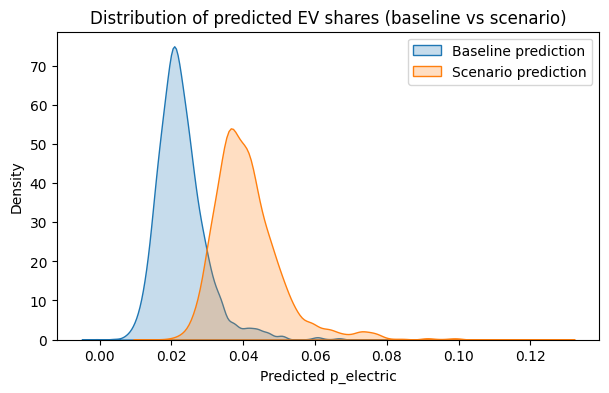

In [15]:
plt.figure(figsize=(7,4))
sns.kdeplot(R["p_electric_hat"], label="Baseline prediction", shade=True)
sns.kdeplot(S["p_electric_hat_scn"], label="Scenario prediction", shade=True)
plt.title("Distribution of predicted EV shares (baseline vs scenario)")
plt.xlabel("Predicted p_electric")
plt.legend()
plt.show()


/tmp/ipython-input-3855816843.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delta_by_cluster,


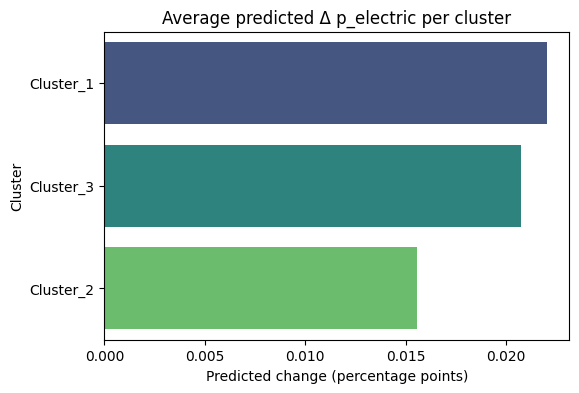

,cluster_label,delta_p_electric_hat
0,Cluster_1,0.0221
2,Cluster_3,0.0207
1,Cluster_2,0.0156


In [16]:
# Mean predicted change per cluster
delta_by_cluster = (
    S.groupby("cluster_label")["delta_p_electric_hat"]
     .mean()
     .reset_index()
     .sort_values("delta_p_electric_hat", ascending=False)
)

plt.figure(figsize=(6,4))
sns.barplot(data=delta_by_cluster,
            y="cluster_label", x="delta_p_electric_hat",
            palette="viridis")
plt.title("Average predicted Δ p_electric per cluster")
plt.xlabel("Predicted change (percentage points)")
plt.ylabel("Cluster")
plt.show()

delta_by_cluster


In [17]:
top10 = S.nlargest(10, "delta_p_electric_hat")[["pc4", "cluster_label", "delta_p_electric_hat"]]
bottom10 = S.nsmallest(10, "delta_p_electric_hat")[["pc4", "cluster_label", "delta_p_electric_hat"]]

print("Top 10 predicted gainers:")
display(top10.style.background_gradient(subset=["delta_p_electric_hat"], cmap="Greens"))

print("Bottom 10 predicted gainers:")
display(bottom10.style.background_gradient(subset=["delta_p_electric_hat"], cmap="Reds"))


Top 10 predicted gainers:


,pc4,cluster_label,delta_p_electric_hat
2879,3899,Cluster_1,0.063173
756,1358,Cluster_1,0.047802
864,1488,Cluster_1,0.047374
2482,3735,Cluster_1,0.043322
865,1489,Cluster_1,0.041217
1656,2111,Cluster_1,0.038821
5354,9086,Cluster_1,0.038545
4445,7735,Cluster_1,0.037727
4446,7735,Cluster_1,0.037727
499,1184,Cluster_1,0.037244


Bottom 10 predicted gainers:


,pc4,cluster_label,delta_p_electric_hat
368,1101,Cluster_3,0.001665
367,1101,Cluster_3,0.003368
4261,7605,Cluster_2,0.007828
4262,7605,Cluster_2,0.007828
3902,7332,Cluster_3,0.008124
4263,7605,Cluster_2,0.009531
5278,8918,Cluster_2,0.009649
3903,7332,Cluster_3,0.009827
5654,9741,Cluster_2,0.009831
5655,9741,Cluster_2,0.009831


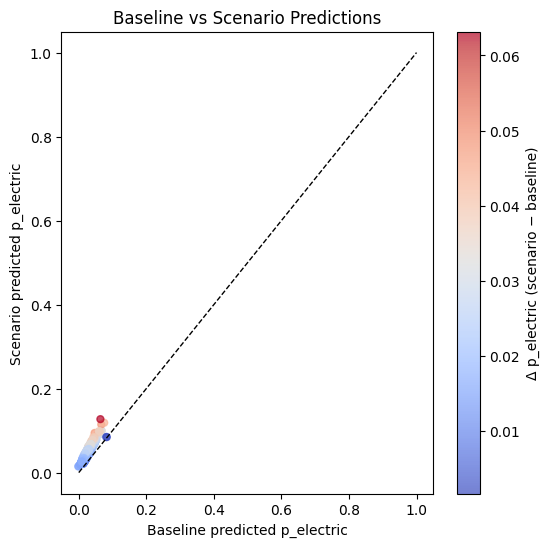

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(R["p_electric_hat"], S["p_electric_hat_scn"],
            c=S["delta_p_electric_hat"], cmap="coolwarm", s=25, alpha=0.7)
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("Baseline predicted p_electric")
plt.ylabel("Scenario predicted p_electric")
plt.title("Baseline vs Scenario Predictions")
cbar = plt.colorbar()
cbar.set_label("Δ p_electric (scenario − baseline)")
plt.show()


## 🔌 OCM pull (with API key): power, connectors, operators, timestamps

We fetch all Netherlands POIs from **OpenChargeMap** and will later aggregate data at **PC4** level (first 4 digits of the postcode).

**Key OCM fields we use**
- `Connections[].PowerKW` → derive counts for **fast** (≥ 50 kW) and **ultra-fast** (≥ 150 kW) ports, total/avg power
- `OperatorInfo.Title`
- `StatusType.IsOperational`
- `DateCreated`, `DateLastStatusUpdate`

**Pipeline outline (this section)**
1. Fetch & flatten OCM POIs ➜ one row per POI (station)
2. Aggregate OCM to **PC4**
3. Resolve **Municipality → PC4** set (using your `conv` mapping)
4. Join **REGIONAL** + **OCM** for those PC4
5. Produce **Top-10 EV usage**, **charger KPIs**, and a **what-if EV transition** forecast

In [68]:
# --- Imports & sanity checks for required dataframes (REGIONAL + municipality mapping) ---
import pandas as pd
import numpy as np
import requests
from typing import List, Dict, Any           # <-- FIX: import typing BEFORE usage
from IPython.display import display

# Must already exist from your previous cells:
# R      -> REGIONAL dataset with features + clusters
# conv   -> mapping DataFrame with ['pc4','gm_name'] for municipality lookup

assert 'R' in globals(), "Missing REGIONAL DataFrame 'R'. Load REGIONAL.csv earlier in the notebook."
assert 'conv' in globals(), "Missing mapping 'conv' with columns ['pc4','gm_name']."

# Clean pc4 types to int for safe joins
R = R.copy()
R['pc4'] = pd.to_numeric(R['pc4'], errors='coerce').astype('Int64')
conv = conv.copy()
conv['pc4'] = pd.to_numeric(conv['pc4'], errors='coerce').astype('Int64')
conv = conv.dropna(subset=['pc4','gm_name'])
conv['pc4'] = conv['pc4'].astype(int)
R_valid = R.dropna(subset=['pc4']).copy()
R_valid['pc4'] = R_valid['pc4'].astype(int)

# If for some reason 'cluster_label' isn't present, fall back to 'ev_cluster'
if 'cluster_label' not in R_valid.columns and 'ev_cluster' in R_valid.columns:
    order = (R_valid.groupby('ev_cluster')['p_electric'].median()
             .sort_values(ascending=False).index.tolist())
    label_map = {c: f"Cluster_{i+1}" for i, c in enumerate(order)}
    R_valid['cluster_label'] = R_valid['ev_cluster'].map(label_map)

### 1) Fetch OpenChargeMap POIs for the Netherlands

We call OCM’s public API with your API key to retrieve all POIs for **NL** in compact JSON format.


In [69]:
# --- OCM fetch ---
OCM_API_KEY = "d8d6328c-6367-4a60-a97c-9db909e524c2"  # ← replace with your real key

_session = requests.Session()
_session.headers.update({
    "User-Agent": "EV-Insights/1.0 (Academic Dashboard)",
    "X-API-Key": OCM_API_KEY
})

def fetch_ocm_nl(maxresults: int = 50000) -> List[Dict[str, Any]]:
    url = "https://api.openchargemap.io/v3/poi/"
    params = {
        "output": "json",
        "countrycode": "NL",
        "maxresults": maxresults,
        "compact": "true",
        "verbose": "false"
    }
    r = _session.get(url, params=params, timeout=180)
    r.raise_for_status()
    return r.json()

print("[info] Fetching OCM POIs for NL…")
ocm_raw = fetch_ocm_nl(maxresults=50000)
print(f"[ok] Retrieved {len(ocm_raw):,} OCM records.")

[info] Fetching OCM POIs for NL…
[ok] Retrieved 8,119 OCM records.


### 2) Flatten OCM JSON ➜ one row per POI (station)

We:
- Extract **PC4** from `AddressInfo.Postcode` (first 4 digits)
- Count **ports**, **fast (≥50kW)**, **ultra-fast (≥150kW)**
- Compute **total/avg power**
- Retain status, operator, and timestamps


In [70]:
def _safe(d: Dict, *keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        cur = cur.get(k)
    return cur if cur is not None else default

def flatten_ocm(records: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for r in records:
        addr = _safe(r, "AddressInfo", default={}) or {}
        pc_raw = addr.get("Postcode", None)
        digits = "".join(ch for ch in str(pc_raw) if ch.isdigit()) if pc_raw is not None else ""
        pc4 = int(digits[:4]) if len(digits) >= 4 else None

        conns = r.get("Connections", []) or []
        n_ports = 0
        total_kw = 0.0
        fast_ports = 0
        ultra_ports = 0
        kw_list = []

        for c in conns:
            n_ports += 1
            kw = c.get("PowerKW", None)
            if kw is None:
                continue
            try:
                kw = float(kw)
                kw_list.append(kw)
                total_kw += kw
                if kw >= 150:
                    ultra_ports += 1
                elif kw >= 50:
                    fast_ports += 1
            except Exception:
                pass

        rows.append({
            "poi_id": r.get("ID"),
            "town": addr.get("Town"),
            "postcode_raw": pc_raw,
            "pc4": pc4,
            "latitude": addr.get("Latitude"),
            "longitude": addr.get("Longitude"),
            "is_operational": bool(_safe(r, "StatusType", "IsOperational", default=np.nan))
                               if _safe(r, "StatusType", "IsOperational", default=None) is not None else np.nan,
            "status_title": _safe(r, "StatusType", "Title"),
            "operator": _safe(r, "OperatorInfo", "Title"),
            "n_ports": n_ports,
            "fast_ports": fast_ports,
            "ultra_fast_ports": ultra_ports,
            "total_power_kw": total_kw,
            "avg_power_kw": (np.mean(kw_list) if kw_list else np.nan),
            "date_created": r.get("DateCreated"),
            "date_last_update": r.get("DateLastStatusUpdate"),
        })

    df = pd.DataFrame(rows)
    if not df.empty:
        df["pc4"] = pd.to_numeric(df["pc4"], errors="coerce").astype("Int64")
    print(f"[ok] Flattened to {len(df):,} POI rows.")
    return df

ocm_flat = flatten_ocm(ocm_raw)


[ok] Flattened to 8,119 POI rows.


### 3) Aggregate OCM at PC4 level

We aggregate station-level rows to **PC4**:
- counts of **stations**, **ports**, **fast/ultra-fast**  
- **total** and **average** power  
- **operational_share** ≈ ratio of operational stations

In [71]:
def ocm_pc4_aggregate(df_flat: pd.DataFrame) -> pd.DataFrame:
    if df_flat is None or df_flat.empty:
        return pd.DataFrame(columns=[
            "pc4","n_stations","n_operational","operational_share",
            "n_ports","fast_ports","ultra_fast_ports",
            "total_power_kw","avg_power_kw"
        ])
    g = (
        df_flat.dropna(subset=["pc4"])
               .groupby("pc4", as_index=False)
               .agg(
                   n_stations=("poi_id", "nunique"),
                   n_operational=("is_operational", lambda s: np.nansum(np.array(s, dtype=float))),
                   n_ports=("n_ports", "sum"),
                   fast_ports=("fast_ports", "sum"),
                   ultra_fast_ports=("ultra_fast_ports", "sum"),
                   total_power_kw=("total_power_kw", "sum"),
                   avg_power_kw=("avg_power_kw", "mean"),
               )
    )
    g["operational_share"] = np.where(g["n_stations"] > 0, g["n_operational"] / g["n_stations"], np.nan)
    g["pc4"] = g["pc4"].astype(int)
    return g[[
        "pc4","n_stations","n_operational","operational_share",
        "n_ports","fast_ports","ultra_fast_ports",
        "total_power_kw","avg_power_kw"
    ]]

ocm_pc4 = ocm_pc4_aggregate(ocm_flat)
print(f"[ok] Aggregated to {len(ocm_pc4):,} PC4 rows.")

[ok] Aggregated to 2,356 PC4 rows.


### 4) Municipality → PC4 lookup

We use your `conv` mapping (`['pc4','gm_name']`) to find all PC4 areas belonging to a municipality name (case-insensitive contains).


In [72]:
def pc4s_for_municipality(gm_query: str, conv_df: pd.DataFrame) -> pd.DataFrame:
    q = gm_query.strip().lower()
    m = conv_df[conv_df["gm_name"].str.lower().str.contains(q, na=False)].copy()
    return m[["pc4","gm_name"]].drop_duplicates()

# Example municipality (you will later wire this to the dashboard input)
MUNICIPALITY = "Utrecht"  # ← change here to test

pc4_map = pc4s_for_municipality(MUNICIPALITY, conv)
if pc4_map.empty:
    raise ValueError(f"No PC4 found for municipality query: '{MUNICIPALITY}'")
print(f"[ok] Found {len(pc4_map)} PC4 under '{MUNICIPALITY}'.")
display(pc4_map.head())


[ok] Found 55 PC4 under 'Utrecht'.


,pc4,gm_name
3186857,3451,Utrecht
3191796,3452,Utrecht
3197098,3453,Utrecht
3200493,3454,Utrecht
3205866,3455,Utrecht


### 5) Join OCM (PC4) with REGIONAL features for that municipality

We join:
- Demographics & EV metrics from **REGIONAL** (`R_valid`)  
- Charger stats from **OCM** (`ocm_pc4`)

We also compute **charger density** KPIs: `chargers_per_10k` and `stations_per_10k`.


In [73]:
mun_pc4s = set(pc4_map["pc4"].tolist())
R_mun = R_valid[R_valid["pc4"].isin(mun_pc4s)].copy()

mun = R_mun.merge(ocm_pc4, on="pc4", how="left")

mun["chargers_per_10k"] = np.where(
    mun["inhabitants_total"] > 0,
    (mun["n_ports"].fillna(0) / mun["inhabitants_total"]) * 10000.0,
    np.nan
)
mun["stations_per_10k"] = np.where(
    mun["inhabitants_total"] > 0,
    (mun["n_stations"].fillna(0) / mun["inhabitants_total"]) * 10000.0,
    np.nan
)

print(f"[ok] Municipality join size: {len(mun):,} PC4")
display(mun.head())

[ok] Municipality join size: 105 PC4


,nbh_code,avg_household_size,avg_house_value_woz,urbanization,std_avg_household_size,std_avg_house_value_woz,std_urbanization,pc4,p_gasoline,p_diesel,...,n_stations,n_operational,operational_share,n_ports,fast_ports,ultra_fast_ports,total_power_kw,avg_power_kw,chargers_per_10k,stations_per_10k
0,03441013,2.5000,564.0000,3.0000,0.5376,0.7897,-0.3674,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
1,03441022,2.7000,542.0000,2.0000,0.9888,0.6599,-1.0423,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
2,03441014,3.2000,"1,015.0000",2.0000,2.1168,3.4510,-1.0423,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
3,03441021,2.9000,597.0000,2.0000,1.4400,0.9845,-1.0423,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676
4,03441012,2.5000,869.0000,5.0000,0.5376,2.5895,0.9824,3451,0.8272,0.1059,...,9.0000,0.0000,0.0000,10.0000,0.0000,0.0000,106.3000,10.5889,7.6307,6.8676


### 6) Top-10 PC4 by current EV usage (`p_electric`)

We rank PC4 areas within the municipality by **current** EV share.

In [74]:
top10_usage = (
    mun[[
        "pc4","cluster_label","p_electric","avg_yearly_income_k","urbanization",
        "n_stations","n_ports","fast_ports","ultra_fast_ports",
        "chargers_per_10k","stations_per_10k"
    ]]
    .sort_values("p_electric", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

display(top10_usage.style.background_gradient(subset=["p_electric"], cmap="Greens"))

,pc4,cluster_label,p_electric,avg_yearly_income_k,urbanization,n_stations,n_ports,fast_ports,ultra_fast_ports,chargers_per_10k,stations_per_10k
0,3545,Cluster_1,0.057519,35.500000,4.000000,nan,nan,nan,nan,0.000000,0.000000
1,3545,Cluster_1,0.057519,35.500000,5.000000,nan,nan,nan,nan,0.000000,0.000000
2,3541,Cluster_1,0.051144,35.900000,1.000000,1.000000,1.000000,0.000000,0.000000,0.976562,0.976562
3,3541,Cluster_1,0.051144,35.900000,1.000000,1.000000,1.000000,0.000000,0.000000,0.976562,0.976562
4,3541,Cluster_1,0.051144,35.900000,1.000000,1.000000,1.000000,0.000000,0.000000,0.976562,0.976562
5,3543,Cluster_1,0.050950,37.400000,4.000000,5.000000,7.000000,0.000000,0.000000,5.998286,4.284490
6,3543,Cluster_1,0.050950,37.400000,2.000000,5.000000,7.000000,0.000000,0.000000,5.998286,4.284490
7,3543,Cluster_1,0.050950,37.400000,2.000000,5.000000,7.000000,0.000000,0.000000,5.998286,4.284490
8,3452,Cluster_1,0.050179,39.900000,2.000000,4.000000,5.000000,0.000000,0.000000,3.294893,2.635914
9,3581,Cluster_1,0.046636,35.100000,1.000000,30.000000,32.000000,0.000000,0.000000,32.339565,30.318343


### 7) What-If EV transition (structural forecast, not time-series)

We fit a **Ridge** model on NL data to predict `p_electric` from:
- `avg_yearly_income_k`, `urbanization`, `p_hybrid`, `p_gasoline`, `p_diesel`

We then simulate a **scenario**:
- **+10%** income, **+0.05** urbanization, **×2** hybrids (capped at 1), **−10%** fossil shares  
and compute the **uplift**: `Δ = p_electric_hat_scn − p_electric_hat`.

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline

X_cols = ["avg_yearly_income_k", "urbanization", "p_hybrid", "p_gasoline", "p_diesel"]
y_col = "p_electric"

# Train on NL (defensive dropna)
R_fit = R_valid.dropna(subset=X_cols + [y_col]).copy()
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 21), cv=5))
]).fit(R_fit[X_cols], R_fit[y_col])

# Baseline prediction for municipality rows with full features
mun_pred = mun.dropna(subset=X_cols).copy()
mun_pred["p_electric_hat"] = model.predict(mun_pred[X_cols])

def scenario_df(df, income_mul=1.0, income_add=0.0, urb_add=0.0,
                hybrid_mul=1.0, fossil_rel_drop=0.0):
    S = df.copy()
    S["avg_yearly_income_k"] = S["avg_yearly_income_k"] * income_mul + income_add
    S["urbanization"] = np.clip(S["urbanization"] + urb_add, 0, 1)
    S["p_hybrid"] = np.clip(S["p_hybrid"] * hybrid_mul, 0, 1)
    S["p_gasoline"] = np.clip(S["p_gasoline"] * (1 - fossil_rel_drop), 0, 1)
    S["p_diesel"]   = np.clip(S["p_diesel"]   * (1 - fossil_rel_drop), 0, 1)
    return S

SCENARIO = dict(income_mul=1.10, urb_add=0.05, hybrid_mul=2.0, fossil_rel_drop=0.10)
S_mun = scenario_df(mun_pred, **SCENARIO)
S_mun["p_electric_hat_scn"] = model.predict(S_mun[X_cols])
S_mun["delta_p_electric_hat"] = S_mun["p_electric_hat_scn"] - mun_pred["p_electric_hat"]

forecast_view = (
    S_mun[[
        "pc4","cluster_label","p_electric","p_electric_hat","p_electric_hat_scn",
        "delta_p_electric_hat",
        "avg_yearly_income_k","urbanization","p_hybrid","p_gasoline","p_diesel",
        "n_stations","n_ports","fast_ports","ultra_fast_ports","chargers_per_10k"
    ]]
    .sort_values("delta_p_electric_hat", ascending=False)
    .reset_index(drop=True)
)

display(forecast_view.head(10).style.background_gradient(subset=["delta_p_electric_hat"], cmap="Blues"))


,pc4,cluster_label,p_electric,p_electric_hat,p_electric_hat_scn,delta_p_electric_hat,avg_yearly_income_k,urbanization,p_hybrid,p_gasoline,p_diesel,n_stations,n_ports,fast_ports,ultra_fast_ports,chargers_per_10k
0,3584,Cluster_1,0.041185,0.025988,0.054234,0.028246,21.560000,1.000000,0.068694,0.720000,0.103541,10.000000,44.000000,0.000000,0.000000,62.190813
1,3545,Cluster_1,0.057519,0.028617,0.056403,0.027786,39.050000,1.000000,0.056124,0.645209,0.162140,nan,nan,nan,nan,0.000000
2,3542,Cluster_3,0.000000,0.027095,0.054100,0.027006,36.190000,1.000000,0.059406,0.650495,0.187129,12.000000,18.000000,0.000000,0.000000,1200.000000
3,3584,Cluster_1,0.041185,0.027691,0.054234,0.026544,21.560000,1.000000,0.068694,0.720000,0.103541,10.000000,44.000000,0.000000,0.000000,62.190813
4,3545,Cluster_1,0.057519,0.030319,0.056403,0.026084,39.050000,1.000000,0.056124,0.645209,0.162140,nan,nan,nan,nan,0.000000
5,3543,Cluster_1,0.050950,0.030253,0.055444,0.025191,41.140000,1.000000,0.051940,0.699005,0.122180,5.000000,7.000000,0.000000,0.000000,5.998286
6,3451,Cluster_1,0.037412,0.025489,0.049903,0.024414,41.470000,1.000000,0.041046,0.744436,0.095306,9.000000,10.000000,0.000000,0.000000,7.630675
7,3454,Cluster_1,0.037617,0.026664,0.048642,0.021978,42.240000,1.000000,0.037744,0.750481,0.091730,15.000000,25.000000,2.000000,1.000000,18.953753
8,3543,Cluster_1,0.050950,0.033659,0.055444,0.021785,41.140000,1.000000,0.051940,0.699005,0.122180,5.000000,7.000000,0.000000,0.000000,5.998286
9,3543,Cluster_1,0.050950,0.033659,0.055444,0.021785,41.140000,1.000000,0.051940,0.699005,0.122180,5.000000,7.000000,0.000000,0.000000,5.998286


### 8) Municipality KPIs and cluster composition

We summarize:
- Municipality-level **KPIs** (counts, charger density)  
- **Cluster composition** (count and mean EV usage per cluster)

In [76]:
mun_kpis = pd.DataFrame({
    "municipality": [MUNICIPALITY],
    "pc4_count": [len(mun)],
    "population_total": [mun["inhabitants_total"].sum(skipna=True)],
    "ev_usage_mean": [mun["p_electric"].mean(skipna=True)],
    "stations_total": [mun["n_stations"].sum(skipna=True)],
    "ports_total": [mun["n_ports"].sum(skipna=True)],
    "fast_ports_total": [mun["fast_ports"].sum(skipna=True)],
    "ultra_ports_total": [mun["ultra_fast_ports"].sum(skipna=True)],
    "chargers_per_10k_mean": [mun["chargers_per_10k"].mean(skipna=True)],
})

cluster_comp = (
    mun.groupby("cluster_label", as_index=False)
       .agg(pc4_count=("pc4","nunique"),
            mean_ev_usage=("p_electric","mean"),
            mean_income=("avg_yearly_income_k","mean"),
            mean_urban=("urbanization","mean"))
       .sort_values(["pc4_count","mean_ev_usage"], ascending=[False, False])
)

display(mun_kpis)
display(cluster_comp)

,municipality,pc4_count,population_total,ev_usage_mean,stations_total,ports_total,fast_ports_total,ultra_ports_total,chargers_per_10k_mean
0,Utrecht,105,"1,025,575.0000",0.0361,583.0000,"1,044.0000",8.0000,4.0000,22.5162


,cluster_label,pc4_count,mean_ev_usage,mean_income,mean_urban
1,Cluster_2,19,0.0308,28.1786,1.0893
0,Cluster_1,18,0.0435,35.2426,1.7660
2,Cluster_3,2,0.0135,32.9000,4.0000


### 9) (Optional) Quick visual checks

These lightweight plots help verify relationships:
- Mean EV usage by cluster  
- EV usage vs charger density  
- Distribution of forecasted uplift

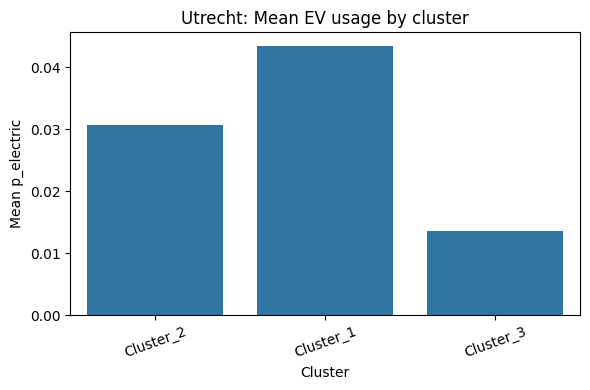

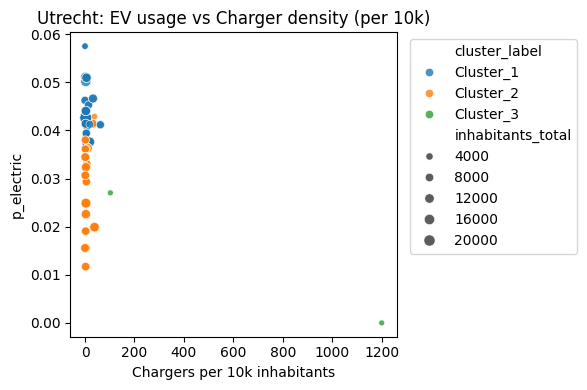

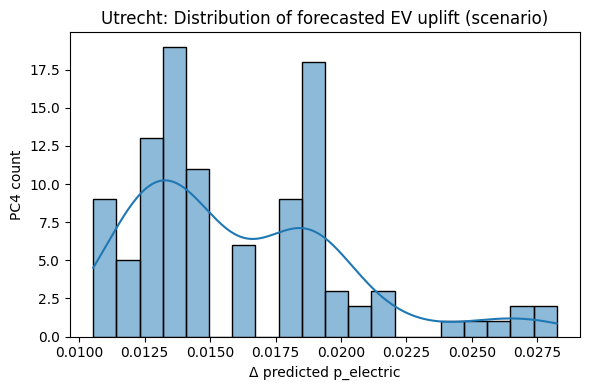

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(data=cluster_comp, x="cluster_label", y="mean_ev_usage")
plt.title(f"{MUNICIPALITY}: Mean EV usage by cluster")
plt.xlabel("Cluster"); plt.ylabel("Mean p_electric")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=mun, x="chargers_per_10k", y="p_electric",
    size="inhabitants_total", hue="cluster_label", alpha=0.8
)
plt.title(f"{MUNICIPALITY}: EV usage vs Charger density (per 10k)")
plt.xlabel("Chargers per 10k inhabitants"); plt.ylabel("p_electric")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(S_mun["delta_p_electric_hat"], bins=20, kde=True)
plt.title(f"{MUNICIPALITY}: Distribution of forecasted EV uplift (scenario)")
plt.xlabel("Δ predicted p_electric"); plt.ylabel("PC4 count")
plt.tight_layout()
plt.show()